In [10]:
import os
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from typing import Tuple, List
import torch
import numpy as np
import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [ ]:
class RobotArm2d():
    """2D PRRR robot arm from ardizzone et al. (prismatic, rotational, rotational, rotational)
    Arm can have more or less rotational joints. Includes INN for inverse kinematics.
    """
    def __init__(self, lengths: list = [1, 0.5, 1, 1, 1, 1], sigmas: list = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], viz_dir: str = "visualizations", data_dir: str = "data"):
        self.cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.cuda else "cpu")
        print(f"Using device: {self.device}")

        self.lengths = torch.tensor(lengths, device=self.device).float()
        self.sigmas = torch.tensor(sigmas, device=self.device).float()

        self.num_joints = self.sigmas.shape[0]
        self.pos_dim = 2  # (x, y)
        self.latent_dim = self.num_joints - self.pos_dim 

        self.num_segments = self.lengths.shape[0] 

        if self.latent_dim < 0:
             raise ValueError(f"Number of joints ({self.num_joints}) must be >= position dimensions ({self.pos_dim})")

        self.num_joints = len(sigmas)
        self.lengths = torch.tensor(lengths)
        self.sigmas = torch.tensor(sigmas)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lengths = self.lengths.to(self.device)
        self.sigmas = self.sigmas.to(self.device)
        self.rangex = (-3, 3)
        self.rangey = (-3, 3)
        self.colors = ['orange', 'red', 'purple'] 
        self.viz_dir = "visualizations"
        os.makedirs(self.viz_dir, exist_ok=True)
        print(f"Using device: {self.device}")


        # --- Visualization & Output ---
        max_prismatic_offset = 3 * self.sigmas[0].item() if self.num_joints > 0 else 0
        total_reach = self.lengths.sum().cpu().item() + abs(max_prismatic_offset)
        plot_margin = 1.15 
        self.rangex = (-total_reach * plot_margin, total_reach * plot_margin)
        self.rangey = (-total_reach * plot_margin, total_reach * plot_margin)
        base_colors = ['orange', 'red', 'purple', 'brown', 'cyan']
        self.colors = [base_colors[i % len(base_colors)] for i in range(self.num_segments)]
        self.out_dir = data_dir
        self.viz_dir = viz_dir
        self.inn_model_file = os.path.join(self.out_dir, f"robot_arm_inn_{self.num_joints}j.pt")

        if not os.path.isdir(self.out_dir):
            os.makedirs(self.out_dir, exist_ok=True)
        if not os.path.isdir(self.viz_dir):
            os.makedirs(self.viz_dir, exist_ok=True)

        # --- INN Model ---

        self.inn = self._build_inn().to(self.device)
        print(f"INN initialized for {self.num_joints} joints ({self.pos_dim} pos + {self.latent_dim} latent) with {sum(p.numel() for p in self.inn.parameters())} parameters.")
        
        self._load_inn_model() 

    def sample_priors(self, batch_size: int = 1) -> torch.Tensor:
        """Normal distributed values of the joint parameters"""
        return torch.randn(batch_size, self.num_joints, device=self.device) * self.sigmas

    def advance_joint(self, current_pos: torch.Tensor, length: torch.Tensor, angle: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculate position of next joint. Ensure length is a tensor."""
        next_pos = current_pos.clone()
        
        length_val = length.item() if length.numel() == 1 else length
        next_pos[:, 0] = next_pos[:, 0] + length_val * torch.cos(angle)
        next_pos[:, 1] = next_pos[:, 1] + length_val * torch.sin(angle)
        return current_pos, next_pos

    def forward(self, thetas: torch.Tensor) -> torch.Tensor:
        """Forward kinematics of given joint configurations"""
        thetas = thetas.to(self.device)
        batch_size = thetas.shape[0]
        angle = torch.zeros(batch_size, device=thetas.device) 
        p_next = torch.stack([torch.zeros(batch_size, device=thetas.device), thetas[:, 0]], dim=1)

        for joint in range(self.num_joints - 1):
            angle = angle + thetas[:, joint + 1]
            length_tensor = self.lengths[joint].to(thetas.device) if self.lengths[joint].device != thetas.device else self.lengths[joint]
            _, p_next = self.advance_joint(p_next, length_tensor, angle)
        return p_next

    def _build_inn(self):
        """Builds the INN model using FrEIA."""
        def subnet_fc(dims_in, dims_out):
            return nn.Sequential(
                nn.Linear(dims_in, 128), nn.LeakyReLU(0.1),
                nn.Linear(128, 128), nn.LeakyReLU(0.1),
                nn.Linear(128, dims_out)
            )

        # Create the INN
        nodes = [Ff.InputNode(self.num_joints, name='input')]
        n_coupling_blocks = 6
        for k in range(n_coupling_blocks): 
            nodes.append(Ff.Node(nodes[-1],
                                Fm.PermuteRandom,
                                {'seed': k},
                                name=f'perm_{k}'))
            nodes.append(Ff.Node(nodes[-1],
                                Fm.GLOWCouplingBlock,
                                {'subnet_constructor': subnet_fc, 'clamp': 1.9},
                                name=f'glow_{k}'))

        nodes.append(Ff.OutputNode(nodes[-1], name='output'))

        return Ff.GraphINN(nodes)

    def _save_inn_model(self):
        """Saves the INN model state."""
        print(f"Saving INN model to {self.inn_model_file}")
        torch.save(self.inn.state_dict(), self.inn_model_file)

    def _load_inn_model(self):
        """Loads the INN model state if it exists."""
        if os.path.exists(self.inn_model_file):
            print(f"Loading INN model from {self.inn_model_file}")
            try:
                 state_dict = torch.load(self.inn_model_file, map_location='cpu')
                 self.inn.load_state_dict(state_dict)
                 self.inn.to(self.device)
                 self.inn.eval()
                 print("INN model loaded successfully.")
            except Exception as e:
                 print(f"Error loading INN model: {e}. Please check architecture or retrain.")
                 print("Proceeding without loaded model.")
        else:
            print("No pre-trained INN model found. Please train the model.")


    def train_inn(self, n_epochs=100, batch_size=512, lr=1e-4, n_samples_train=500000, n_samples_val=50000, weight_fk=10.0, weight_latent=1.0, weight_rev=5.0):
        """Trains the INN model."""
        print("Starting INN training...")
        self.inn.train() 
        optimizer = optim.Adam(self.inn.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)


        # Loss functions
        mse_loss = nn.MSELoss()
        print("Generating validation data...")
        with torch.no_grad(): 
            thetas_val = self.sample_priors(n_samples_val)
            pos_val = self.forward(thetas_val).detach() 

        best_val_loss = float('inf')
        start_time = time.time()

        for epoch in range(n_epochs):
            epoch_loss_f = 0.0
            epoch_loss_z = 0.0
            epoch_loss_rev = 0.0
            epoch_loss_total = 0.0
            n_batches = max(1, n_samples_train // batch_size) 

            self.inn.train()
            for i in range(n_batches):
                optimizer.zero_grad()


                # forawrd pass    
                with torch.no_grad():
                    thetas_batch = self.sample_priors(batch_size)
                    pos_batch_gt = self.forward(thetas_batch).detach()

                # Pass thetas through INN (track grads here)
                out_inn_tensor, _ = self.inn(thetas_batch) # UNPACKED TUPLE
                pos_pred = out_inn_tensor[:, :self.pos_dim]
                z_pred = out_inn_tensor[:, self.pos_dim:]

                # Forward Loss (FK reconstruction)
                loss_f = mse_loss(pos_pred, pos_batch_gt)

                loss_z = torch.mean(z_pred**2) / 2.0 
                # --- Reverse Pass ---
                z_rev_sample = torch.randn(batch_size, self.latent_dim, device=self.device)
                rev_input = torch.cat((pos_batch_gt, z_rev_sample), dim=1)

                thetas_rev_pred_tensor, _ = self.inn(rev_input, rev=True) 

                pos_rev_pred = self.forward(thetas_rev_pred_tensor)
                loss_rev = mse_loss(pos_rev_pred, pos_batch_gt)

                # Total Loss
                total_loss = weight_fk * loss_f + weight_latent * loss_z + weight_rev * loss_rev

                total_loss.backward()
                optimizer.step()

                epoch_loss_f += loss_f.item()
                epoch_loss_z += loss_z.item()
                epoch_loss_rev += loss_rev.item()
                epoch_loss_total += total_loss.item()

                if (i + 1) % max(1, n_batches // 10) == 0 or i == n_batches - 1:
                    print(f"  Batch {i+1}/{n_batches} - Loss: {total_loss.item():.4f} (Fk:{loss_f.item():.4f}, Z:{loss_z.item():.4f}, Rev:{loss_rev.item():.4f})", end='\r')

            avg_epoch_loss_f = epoch_loss_f / n_batches
            avg_epoch_loss_z = epoch_loss_z / n_batches
            avg_epoch_loss_rev = epoch_loss_rev / n_batches
            avg_epoch_loss = epoch_loss_total / n_batches


            # --- Validation ---
            self.inn.eval() 
            with torch.no_grad():
                val_loss_f = 0.0
                val_loss_z = 0.0
                val_loss_rev = 0.0
                val_loss_total = 0.0
                n_val_batches = max(1, n_samples_val // batch_size)

                for j in range(n_val_batches):
                    start_idx = j * batch_size
                    end_idx = min((j + 1) * batch_size, n_samples_val)
                    if start_idx >= end_idx: continue 

                    thetas_val_batch = thetas_val[start_idx:end_idx]
                    pos_val_batch_gt = pos_val[start_idx:end_idx]
                    current_batch_size = thetas_val_batch.shape[0] 

                    # Forward
                    out_val_tensor, _ = self.inn(thetas_val_batch)
                    pos_val_pred = out_val_tensor[:, :self.pos_dim]
                    z_val_pred = out_val_tensor[:, self.pos_dim:]
                    loss_f_val = mse_loss(pos_val_pred, pos_val_batch_gt)
                    loss_z_val = torch.mean(z_val_pred**2) / 2.0

                    z_val_rev_sample = torch.randn(current_batch_size, self.latent_dim, device=self.device)
                    rev_val_input = torch.cat((pos_val_batch_gt, z_val_rev_sample), dim=1)
                    thetas_val_rev_pred_tensor, _ = self.inn(rev_val_input, rev=True) 
                    pos_val_rev_pred = self.forward(thetas_val_rev_pred_tensor)
                    loss_rev_val = mse_loss(pos_val_rev_pred, pos_val_batch_gt)

                    total_val_loss_batch = weight_fk * loss_f_val + weight_latent * loss_z_val + weight_rev * loss_rev_val
                    val_loss_total += total_val_loss_batch.item() * current_batch_size


            avg_val_loss = val_loss_total / n_samples_val
            elapsed_time = time.time() - start_time

            print(f"Epoch {epoch+1}/{n_epochs} - Time: {elapsed_time:.1f}s - Train Loss: {avg_epoch_loss:.4f} (F:{avg_epoch_loss_f:.4f} Z:{avg_epoch_loss_z:.4f} R:{avg_epoch_loss_rev:.4f}) - Val Loss: {avg_val_loss:.4f}")

            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                print(f"Validation loss improved ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Saving model.")
                best_val_loss = avg_val_loss
                self._save_inn_model()
            elif epoch > 15 and optimizer.param_groups[0]['lr'] < 1e-6:
                 print("Learning rate too low, stopping early.")
                 break

        print("Training finished.")
        print("Loading best model found during training.")
        self._load_inn_model()
        self.inn.eval() 


    def inverse_inn(self, pos_target: torch.Tensor, n_samples: int = 1000) -> torch.Tensor:
        """Performs inverse kinematics using the trained INN.

        :param pos_target: Target end effector position(s), shape (n_targets, 2)
        :param n_samples: Number of inverse solutions to generate *per target*.
        :return: Tensor of joint parameters, shape (n_targets * n_samples, num_joints)
        """
        self.inn.eval() 
        n_targets = pos_target.shape[0]
        pos_target = pos_target.to(self.device)

        if self.latent_dim <= 0 and n_samples > 1:
             print("Warning: num_joints == pos_dim. Only one latent state (zero vector) is possible.")
             n_samples = 1 

        with torch.no_grad():
            if self.latent_dim > 0:
                z_samples = torch.randn(n_targets * n_samples, self.latent_dim, device=self.device)
            else:
                 # Handle case with no latent dimensions (num_joints == pos_dim)
                 z_samples = torch.empty(n_targets * n_samples, 0, device=self.device)

            pos_target_rep = pos_target.repeat_interleave(n_samples, dim=0)

            rev_input = torch.cat((pos_target_rep, z_samples), dim=1)

            thetas_pred_tensor, _ = self.inn(rev_input, rev=True)

        return thetas_pred_tensor 

    def init_plot(self) -> Tuple[plt.Figure, plt.Axes]:
        """Initialize matplotlib figure"""
        fig, ax = plt.subplots(figsize=(6 , 6))
        return fig, ax

    def advance_joint(self, current_pos: torch.Tensor, length: torch.Tensor, angle: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Dummy advance_joint for example"""
        next_pos = current_pos.clone()
        length_val = length.item() if length.numel() == 1 else length
        next_pos[:, 0] = next_pos[:, 0] + length_val * torch.cos(angle)
        next_pos[:, 1] = next_pos[:, 1] + length_val * torch.sin(angle)
        return current_pos, next_pos

    def distance_euclidean(self, pos_target: torch.Tensor, pos_pred: torch.Tensor) -> float:
        """Dummy distance calculation for example"""
        if pos_pred.shape[0] == 0 or pos_target.shape[0] == 0:
            return float('nan')
        pos_target = pos_target.to(self.device)
        pos_pred = pos_pred.to(self.device)
        # Simple case assuming n_samples=pred.shape[0] / target.shape[0]
        n_samples = pos_pred.shape[0] // pos_target.shape[0]
        if n_samples == 0: n_samples = 1 # Handle edge case
        target_expanded = pos_target.repeat_interleave(n_samples, dim=0)
        if target_expanded.shape[0] != pos_pred.shape[0]: # Fallback if shapes mismatch
             return torch.cdist(pos_pred, pos_target).mean().item()

        distances = torch.sqrt(((pos_pred - target_expanded) ** 2).sum(dim=1))
        return distances.mean().item()

    # ****** MODIFIED FUNCTION ******
    def viz_inverse(self, pos_target: torch.Tensor, thetas: torch.Tensor, save: bool = True, show: bool = False, fig_name: str = "fig_inverse_inn", viz_format: tuple = (".png", ".svg"), ax: plt.Axes = None) -> Tuple[plt.Axes, float]:
        """Visualize inverse kinematics solutions, adding circles for end effectors."""
        if not isinstance(thetas, torch.Tensor):
            raise TypeError(f"Expected 'thetas' to be a torch.Tensor, but got {type(thetas)}")

        if ax is None:
            passed_ax = False
            fig, ax = self.init_plot()
        else:
            passed_ax = True
            fig = ax.figure 

        # Options for arm segments (quiver)
        segment_opts = {'alpha': 0.15, 
                        'scale': 1,
                        'angles': 'xy',
                        'scale_units': 'xy',
                        'headlength': 0,
                        'headaxislength': 0,
                        'linewidth': 1.0,
                        'rasterized': True} 
        # Options for end-effector points (scatter)
        ee_opts = {'alpha': 0.2, 
                   's': 1,       
                   'marker': 'o',
                   'color': 'green',
                   'label': 'End Effectors', 
                   'zorder': 6 } 

        # --- Perform FK Calculation for Visualization ---
        n_solutions = thetas.shape[0]
        p_final = torch.empty(0, 2, device=self.device) 

        if n_solutions > 0:
            thetas = thetas.to(self.device) 
            angle = torch.zeros(n_solutions, device=self.device)
            p_current = torch.stack([torch.zeros(n_solutions, device=self.device), thetas[:, 0]], dim=1)

            # Loop through segments
            for joint_idx in range(self.num_segments):
                angle += thetas[:, joint_idx + 1] 
                length_tensor = self.lengths[joint_idx].to(thetas.device) 
                p_start, p_end = self.advance_joint(p_current, length_tensor, angle)

                # Detach and move to CPU for plotting segments
                p_start_np = p_start.detach().cpu().numpy()
                p_end_np = p_end.detach().cpu().numpy()

                # Plot Segment using appropriate color
                segment_color = self.colors[joint_idx % len(self.colors)]
                ax.quiver(p_start_np[:, 0], p_start_np[:, 1],
                          (p_end_np - p_start_np)[:, 0], (p_end_np - p_start_np)[:, 1],
                          color=segment_color, **segment_opts)

                p_current = p_end 

            p_final = p_current
        else:
             print("Warning: No solutions provided for visualization.")


        # --- Plot End Effector Points ---
        if n_solutions > 0:
            p_final_np = p_final.detach().cpu().numpy()
            ax.scatter(p_final_np[:, 0], p_final_np[:, 1], **ee_opts)
        # --- End Plotting End Effector Points ---


        # --- Calculate Distance & Plot Target ---
        distance = self.distance_euclidean(pos_target, p_final)

        pos_target_np = pos_target.cpu().numpy()
        # ax.scatter(pos_target_np[:, 0], pos_target_np[:, 1], marker='x', color='blue', s=150, alpha=1.0, linewidth=2.5, label='Target(s)', zorder=10)

        # --- Final Plot Styling ---
        ax.set_xlim(*self.rangex)
        ax.set_ylim(*self.rangey)
        ax.set_aspect('equal', adjustable='box')
        ax.axvline(x=0, ls=':', c='grey', linewidth=.7)
        ax.axhline(y=0, ls=':', c='grey', linewidth=.7)
        title = f"Inverse Kinematics (INN) - {n_solutions} samples"
        if not np.isnan(distance):
            title += f"\nMean Euclidean Distance = {distance:.4f}"
        ax.set_title(title)
        ax.set_xlabel("X Position (y2)")
        ax.set_ylabel("Y Position (y1)")
        ax.grid(True, linestyle=':', alpha=0.6) 
        if n_solutions > 0: 
            ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0., markerscale=4.0)


        if save and not passed_ax:
            for fmt in viz_format:
                fmt_cleaned = fmt if fmt.startswith('.') else '.' + fmt
                full_path = os.path.join(self.viz_dir, fig_name) + fmt_cleaned
                print(f"Saving visualization to {full_path}")
                try:
                    fig.savefig(full_path, bbox_inches='tight', dpi=400) 
                except Exception as e:
                    print(f"Error saving figure to {full_path}: {e}")
        if show and not passed_ax:
            plt.show()
        if not passed_ax:
            plt.close(fig)

        return ax, distance


Using device: cuda
Using device: cuda
INN initialized for 4 joints (2 pos + 2 latent) with 208992 parameters.
Loading INN model from data/robot_arm_inn_4j.pt
INN model loaded successfully.
--- Skipping Training (using loaded model or model file exists) ---

--- Generating 100 inverse solutions for target(s): [[2. 0.]] ---
Loading INN model from data/robot_arm_inn_4j.pt
INN model loaded successfully.
Time to generate solutions: 0.081 seconds
Generated 100 configurations.

--- Visualizing Results ---
Saving visualization to visualizations/inverse_inn_4j_100s_x2p0_y0p0.png
Saving visualization to visualizations/inverse_inn_4j_100s_x2p0_y0p0.svg


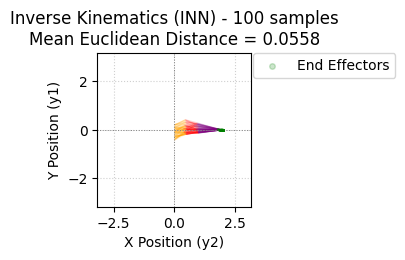


--- Script Finished ---


In [ ]:
TRAIN_MODEL = False

N_JOINTS = 4

LENGTHS = [0.5, 0.5, 1][:N_JOINTS-1]

SIGMAS = [0.25] + [0.5]*(N_JOINTS-1)

target_pos = torch.tensor([[2, 0]], device="cpu").float() 
num_inverse_samples = 100
arm = RobotArm2d(lengths=LENGTHS, sigmas=SIGMAS)
if TRAIN_MODEL or not os.path.exists(arm.inn_model_file):
    print("\n--- Starting INN Training (Proper Run) ---")
    arm.train_inn(
        n_epochs=50,          
        batch_size=4912*8,     
        lr=3e-4,            
        n_samples_train=1000000, 
        n_samples_val=50000,
        weight_fk=50.0,   
        weight_latent=0.5,   
        weight_rev=100.0       
    )
    print("--- Training Complete ---")
else:
    print("--- Skipping Training (using loaded model or model file exists) ---")

print(f"\n--- Generating {num_inverse_samples} inverse solutions for target(s): {target_pos.numpy()} ---")
start_time = time.time()

if not TRAIN_MODEL and not os.path.exists(arm.inn_model_file):
        print("ERROR: No model trained or loaded. Cannot perform inverse kinematics.")
        exit()
elif not TRAIN_MODEL:
        arm._load_inn_model()
        if not next(arm.inn.parameters()).is_cuda and arm.device == torch.device("cuda"):
            print("Warning: Model loaded to CPU but device is CUDA. Moving model to CUDA.")
            arm.inn.to(arm.device)


thetas_generated_inn = arm.inverse_inn(target_pos, n_samples=num_inverse_samples)
time_taken = time.time() - start_time
print(f"Time to generate solutions: {time_taken:.3f} seconds")
if isinstance(thetas_generated_inn, torch.Tensor):
    print(f"Generated {thetas_generated_inn.shape[0]} configurations.")
else:
    print(f"Error: inverse_inn did not return a tensor. Type: {type(thetas_generated_inn)}")
    exit()


# --- Visualization ---
if thetas_generated_inn.shape[0] > 0:
    print("\n--- Visualizing Results ---")
    target_name_list = []
    for k in range(target_pos.shape[0]):
        target_name_list.append(f"x{target_pos[k,0].item():.1f}_y{target_pos[k,1].item():.1f}")
    target_name = "_".join(target_name_list).replace('.', 'p').replace('-','m')

    fig_name=f"inverse_inn_{arm.num_joints}j_{num_inverse_samples}s_{target_name}"
    arm.viz_inverse(
        target_pos,
        thetas_generated_inn,
        fig_name=fig_name,
        show=True,
        save=True  
    )
else:
    print("\n--- Skipping Visualization (No solutions generated) ---")

print("\n--- Script Finished ---")